## Imports

In [3]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import polars.selectors as cs
from strip_markdown import strip_markdown
from janitor.polars import clean_names
from ydata_profiling import ProfileReport
import altair as alt
from google import genai
import os

## Environment Variables

In [6]:
load_dotenv(dotenv_path='secret.env')
GEMINI_API_KEY= os.getenv("gem")
alt.data_transformers.enable("vegafusion")


DataTransformerRegistry.enable('vegafusion')

# Dataset Deals

In [7]:
df = pl.read_csv("data/Project_Phase1.csv")
Pandas_df = pd.read_csv("data/Project_Phase1.csv")

In [4]:
df.shape

(14036, 31)

In [5]:
df.schema

Schema([('syn_error_rate', Float64),
        ('connection_time', Int64),
        ('destination_same_source_port_rate', Float64),
        ('destination_different_server_rate', Float64),
        ('connection_status', String),
        ('connection_count', Int64),
        ('destination_server_different_host_rate', Float64),
        ('suspicious_activity', Int64),
        ('protocol', String),
        ('server_different_host_rate', Float64),
        ('destination_server_syn_error_rate', Float64),
        ('destination_host_server_count', Int64),
        ('destination_same_server_rate', Float64),
        ('fragment_errors', Int64),
        ('compromised_count', Int64),
        ('source_bytes', Int64),
        ('service_type', String),
        ('destination_syn_error_rate', Float64),
        ('same_server_rate', Float64),
        ('reset_error_rate', Float64),
        ('server_request_count', Int64),
        ('destination_server_reset_error_rate', Float64),
        ('server_reset_error_rate',

In [3]:
df = clean_names(df = df , case_type='lower', remove_special=True, strip_accents=True , strip_underscores=True , truncate_limit=None)

In [5]:
df.null_count()

syn_error_rate,connection_time,destination_same_source_port_rate,destination_different_server_rate,connection_status,connection_count,destination_server_different_host_rate,suspicious_activity,protocol,server_different_host_rate,destination_server_syn_error_rate,destination_host_server_count,destination_same_server_rate,fragment_errors,compromised_count,source_bytes,service_type,destination_syn_error_rate,same_server_rate,reset_error_rate,server_request_count,destination_server_reset_error_rate,server_reset_error_rate,server_syn_error_rate,destination_bytes,guest_login,authentication_status,destination_host_count,destination_reset_error_rate,different_server_rate,class
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df.select(cs.numeric()).describe()

statistic,syn_error_rate,connection_time,destination_same_source_port_rate,destination_different_server_rate,connection_count,destination_server_different_host_rate,suspicious_activity,server_different_host_rate,destination_server_syn_error_rate,destination_host_server_count,destination_same_server_rate,fragment_errors,compromised_count,source_bytes,destination_syn_error_rate,same_server_rate,reset_error_rate,server_request_count,destination_server_reset_error_rate,server_reset_error_rate,server_syn_error_rate,destination_bytes,guest_login,authentication_status,destination_host_count,destination_reset_error_rate,different_server_rate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0,14036.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.039788,184.191294,0.122315,0.044255,28.048019,0.025829,0.221288,0.122144,0.032572,182.678755,0.783955,0.001567,0.393346,11341.807922,0.039907,0.94019,0.048265,27.400328,0.048468,0.049172,0.037901,4226.110074,0.012183,0.681177,151.48625,0.050431,0.032923
"""std""",0.183392,1448.60408,0.257433,0.135233,63.798968,0.07139,2.327768,0.266557,0.168483,97.214193,0.348346,0.06751,13.949886,169682.168932,0.180893,0.211918,0.211091,60.297916,0.20034,0.211871,0.179243,68334.655301,0.109706,0.466037,101.76511,0.203809,0.151932
"""min""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,93.0,0.65,0.0,0.0,78.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,72.0,0.0,0.0,43.0,0.0,0.0
"""50%""",0.0,0.0,0.01,0.0,5.0,0.0,0.0,0.0,0.0,254.0,1.0,0.0,0.0,229.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,347.0,0.0,1.0,168.0,0.0,0.0
"""75%""",0.0,0.0,0.08,0.02,15.0,0.03,0.0,0.1,0.0,255.0,1.0,0.0,0.0,323.0,0.0,1.0,0.0,18.0,0.0,0.0,0.0,1924.0,0.0,1.0,255.0,0.0,0.0
"""max""",1.0,41476.0,1.0,1.0,511.0,1.0,77.0,1.0,1.0,255.0,1.0,3.0,884.0,7.665876e6,1.0,1.0,1.0,511.0,1.0,1.0,1.0,5.131424e6,1.0,1.0,255.0,1.0,1.0


In [53]:
df.select(cs.string()).describe()

statistic,connection_status,protocol,service_type,class
str,str,str,str,str
"""count""","""14036""","""14036""","""14036""","""14036"""
"""null_count""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null
"""std""",null,null,null,null
"""min""","""OTH""","""icmp""","""IRC""","""anomaly"""
"""25%""",null,null,null,null
"""50%""",null,null,null,null
"""75%""",null,null,null,null
"""max""","""SF""","""udp""","""whois""","""normal"""


In [10]:
profile = ProfileReport(Pandas_df, title="Pred-Sus-Act Report" , lazy=True , explorative=True , tsmode=True)

In [ ]:
profile.to_file("data/report.html")

In [ ]:
del Pandas_df

In [8]:
df.columns

['syn_error_rate',
 'connection_time',
 'destination_same_source_port_rate',
 'destination_different_server_rate',
 'connection_status',
 'connection_count',
 'destination_server_different_host_rate',
 'suspicious_activity',
 'protocol',
 'server_different_host_rate',
 'destination_server_syn_error_rate',
 'destination_host_server_count',
 'destination_same_server_rate',
 'fragment_errors',
 'compromised_count',
 'source_bytes',
 'service_type',
 'destination_syn_error_rate',
 'same_server_rate',
 'reset_error_rate',
 'server_request_count',
 'destination_server_reset_error_rate',
 'server_reset_error_rate',
 'server_syn_error_rate',
 'destination_bytes',
 'guest_login',
 'authentication_status',
 'destination_host_count',
 'destination_reset_error_rate',
 'different_server_rate',
 'target']

In [4]:
df = df.rename({"class": "target"})

## Extra Visuals

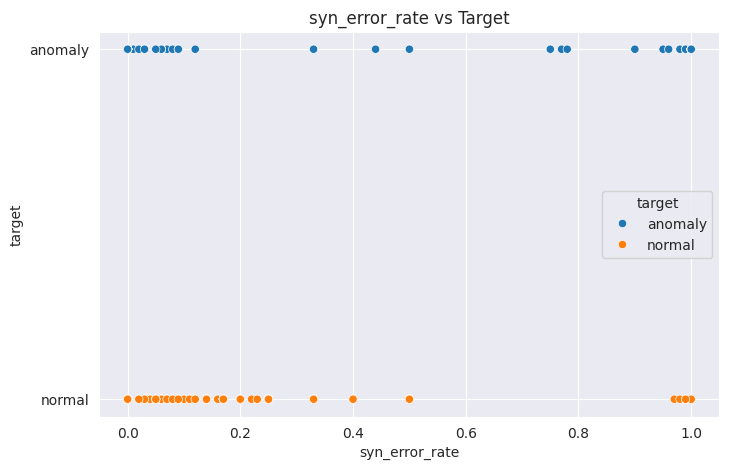

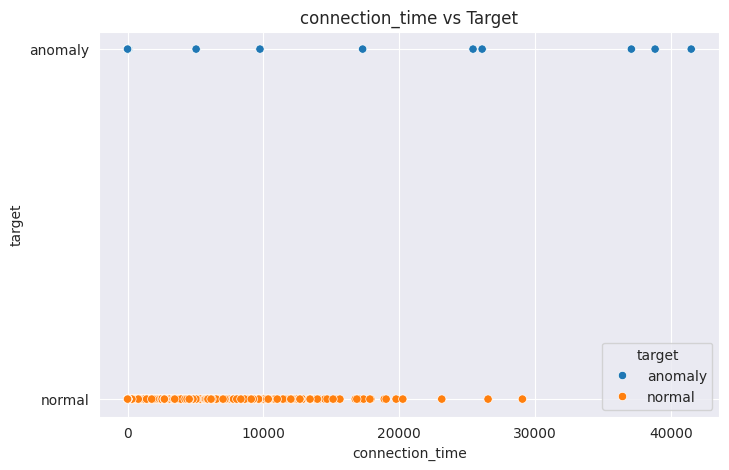

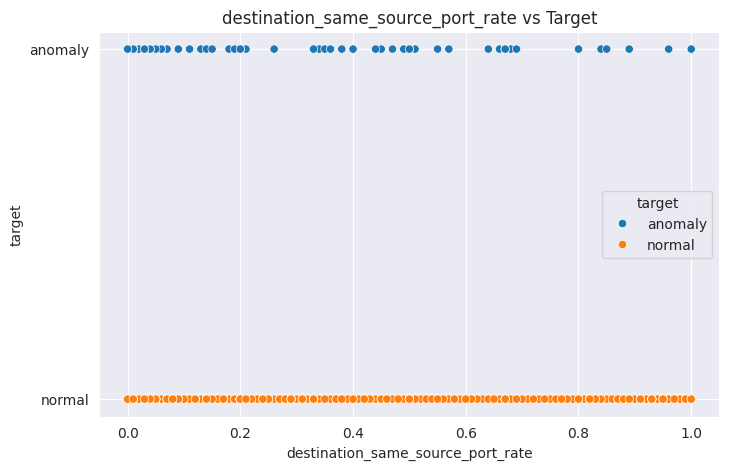

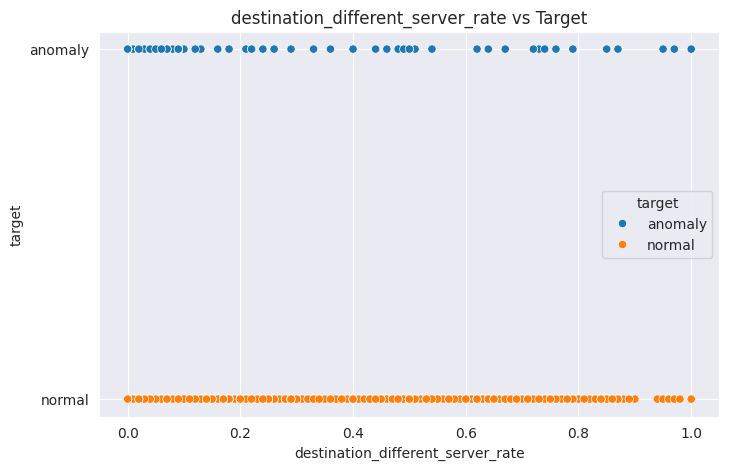

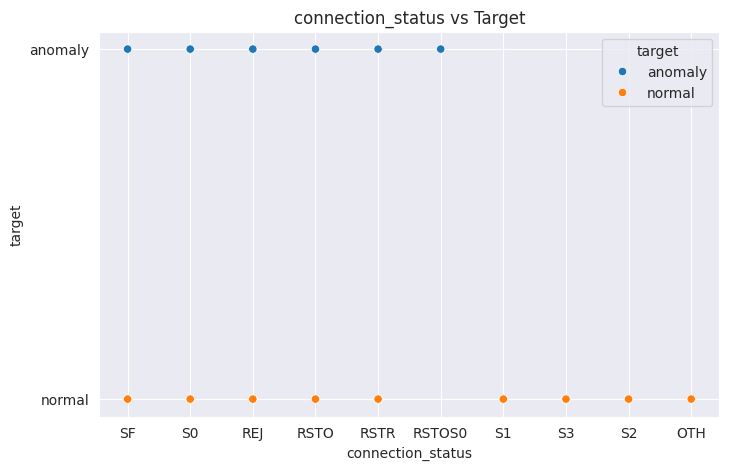

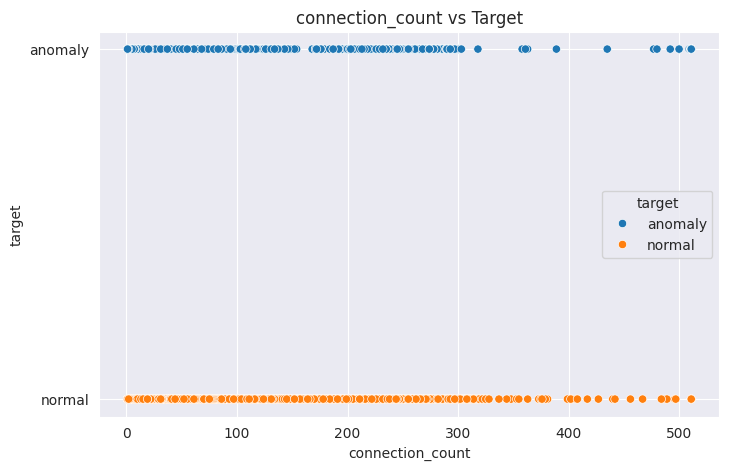

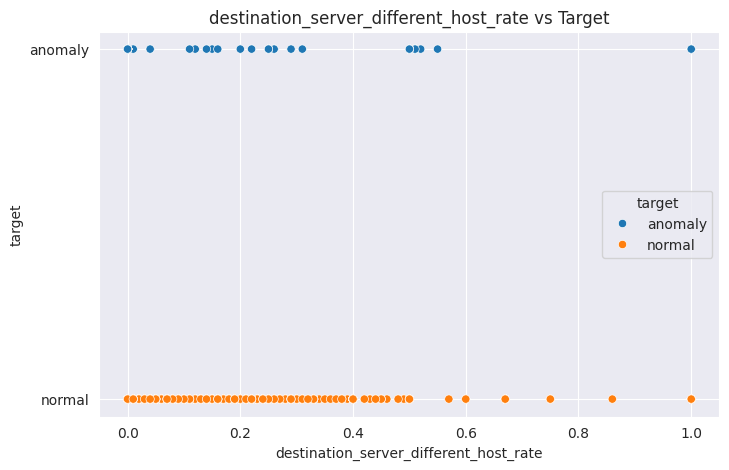

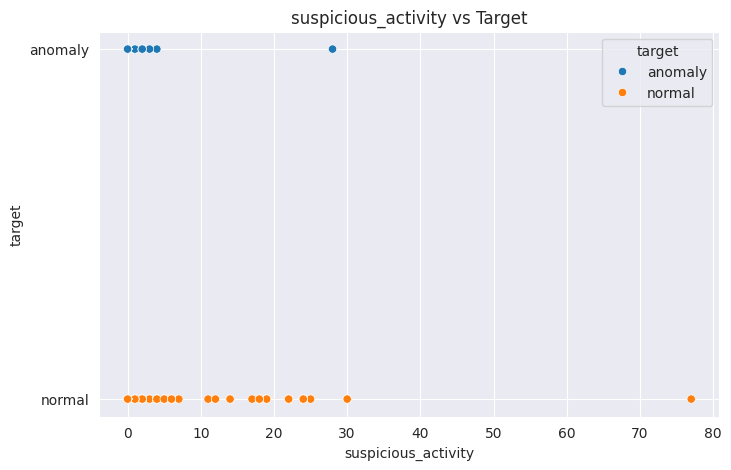

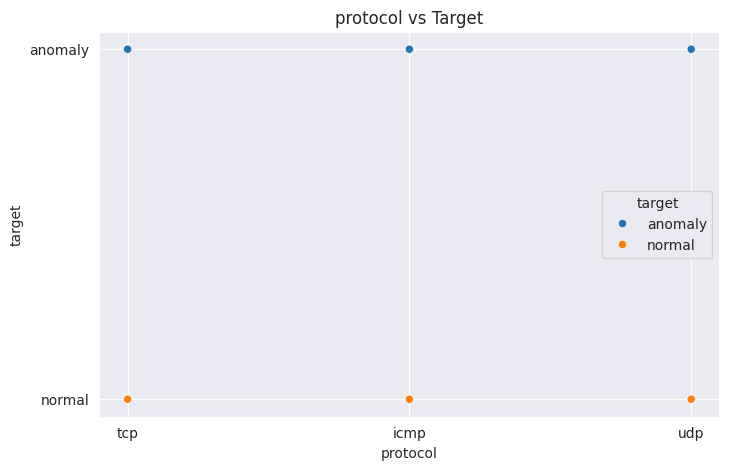

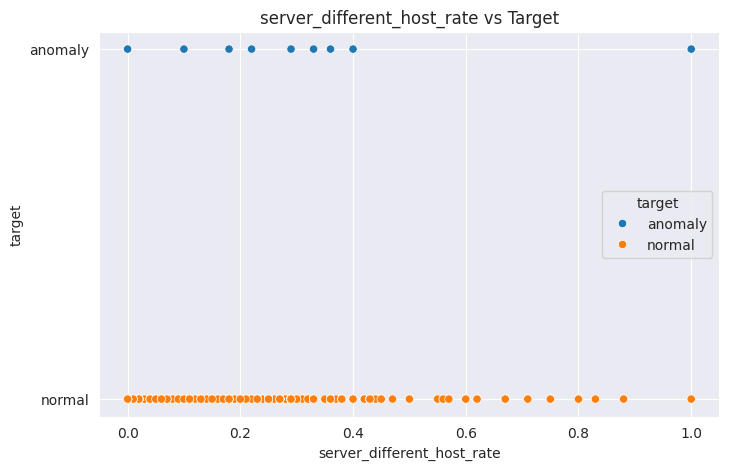

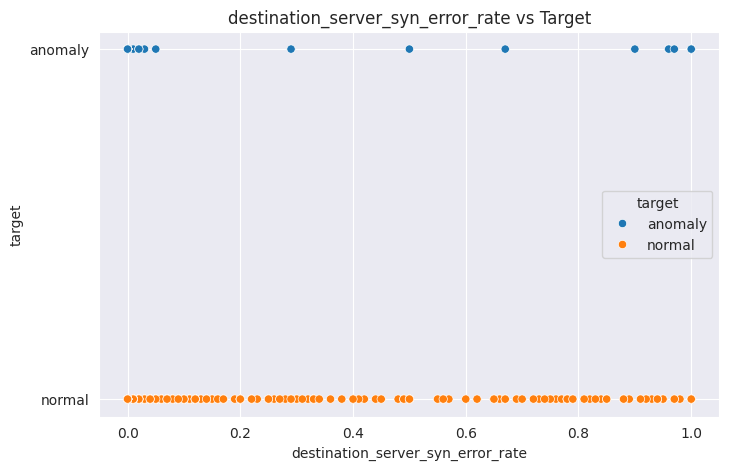

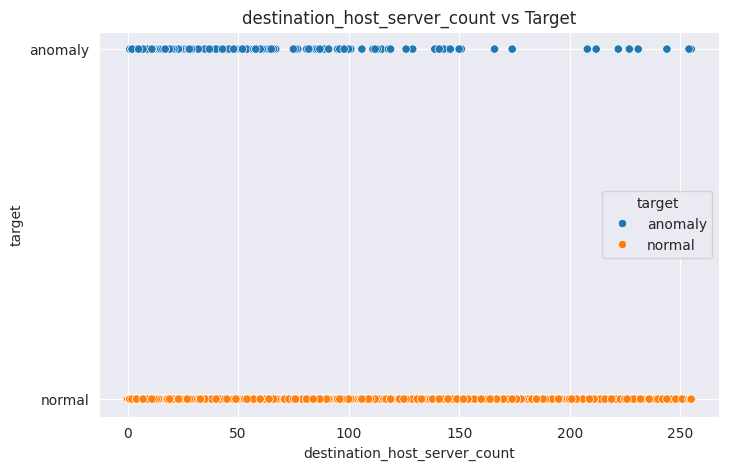

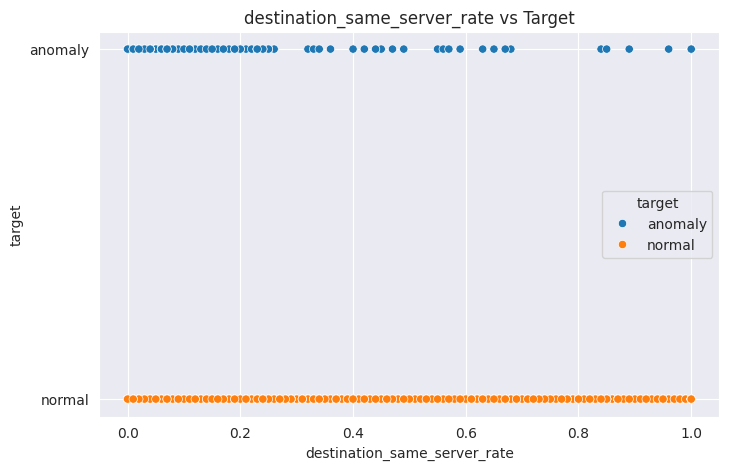

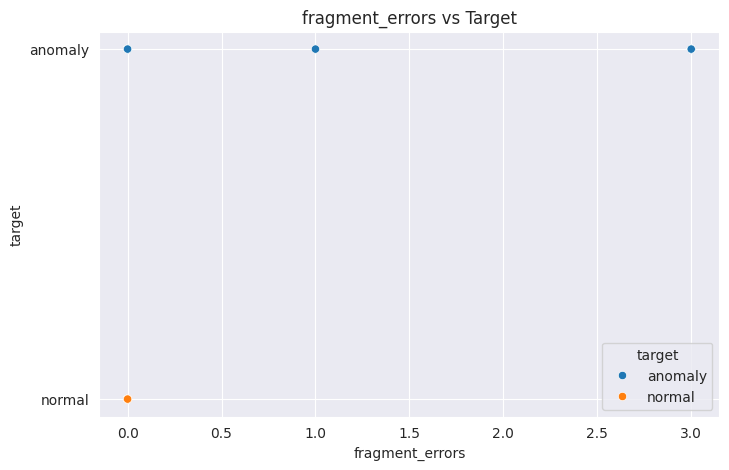

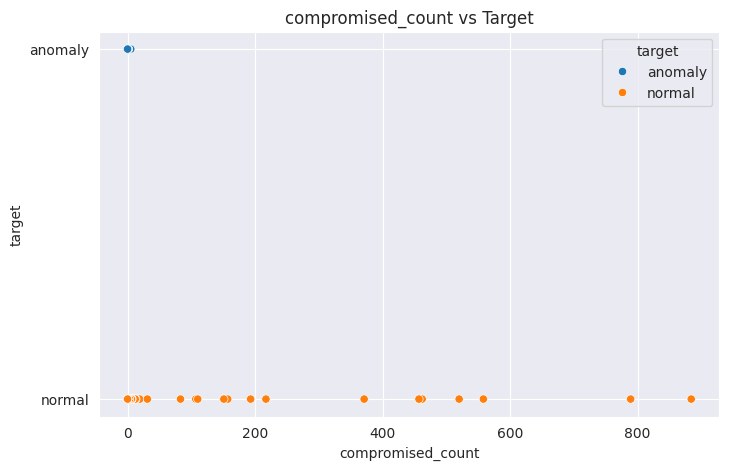

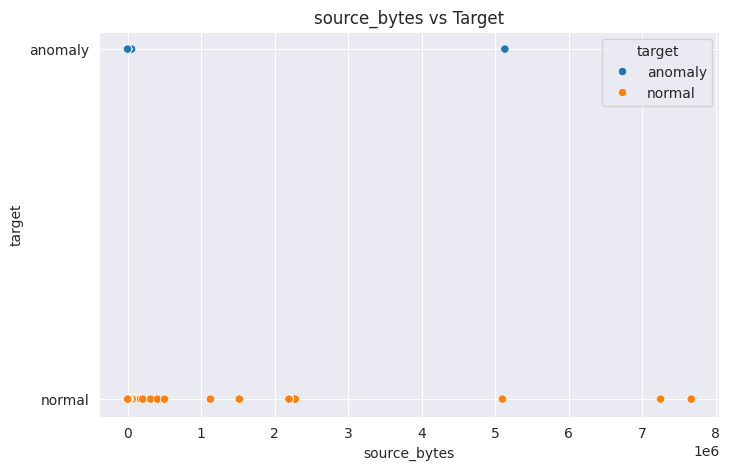

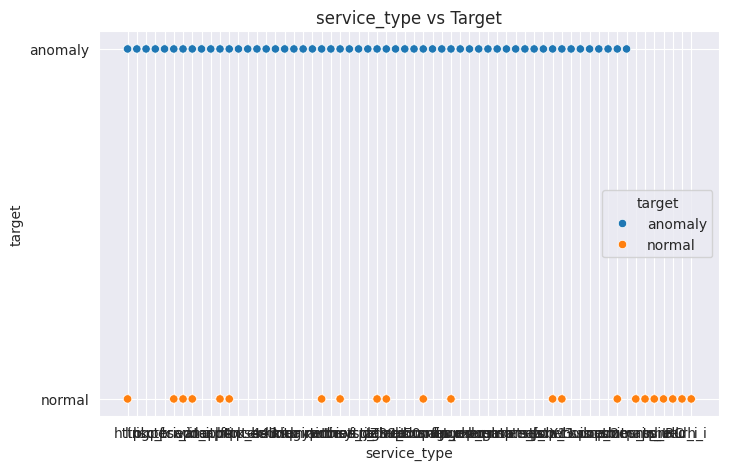

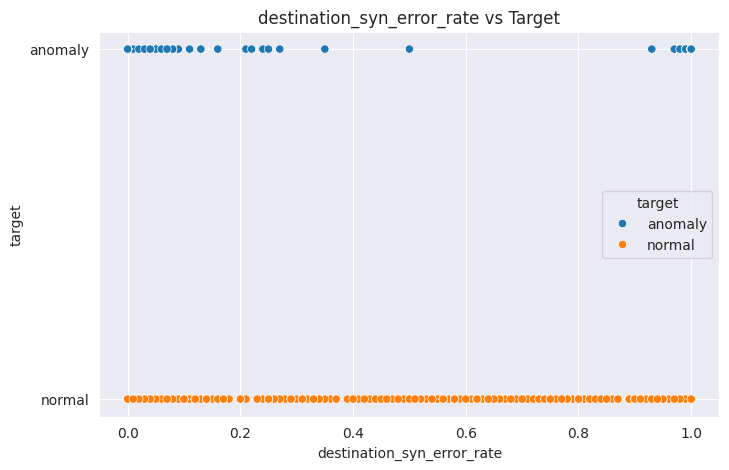

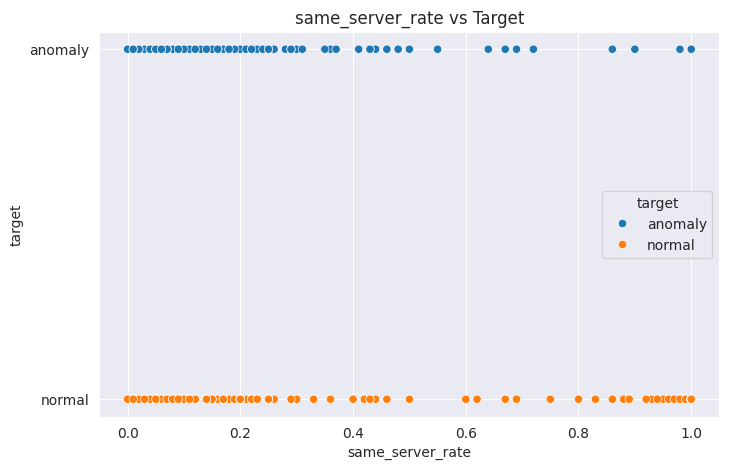

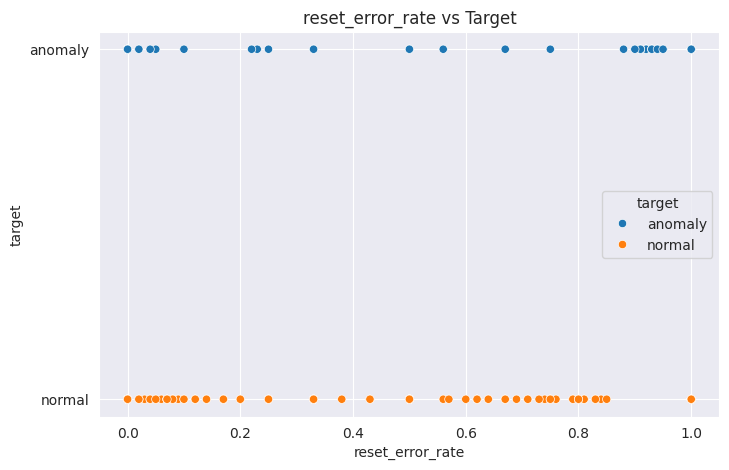

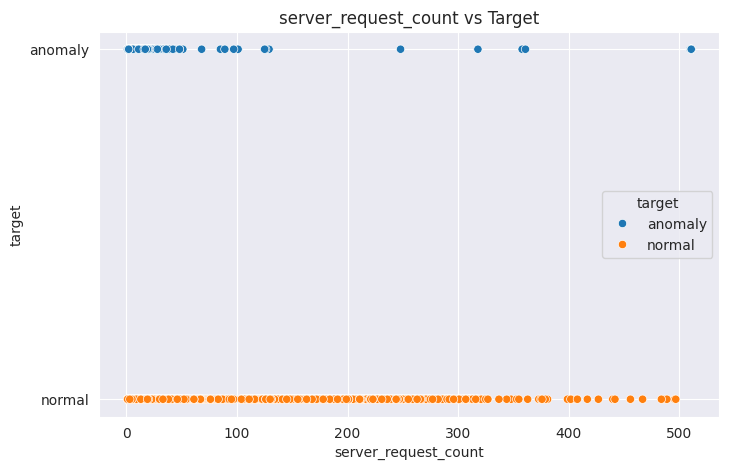

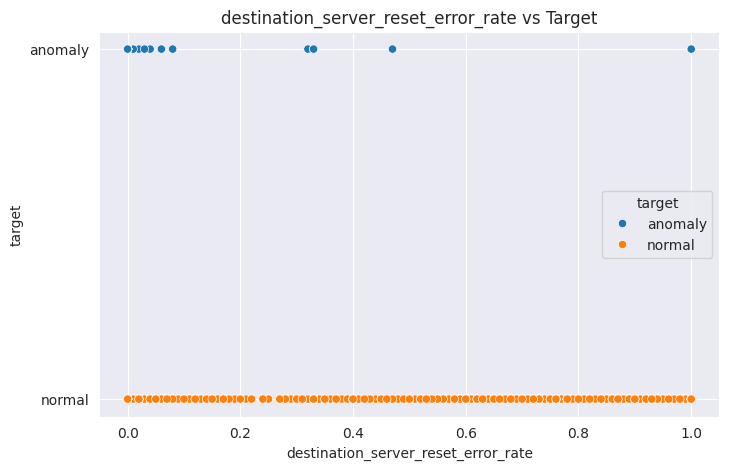

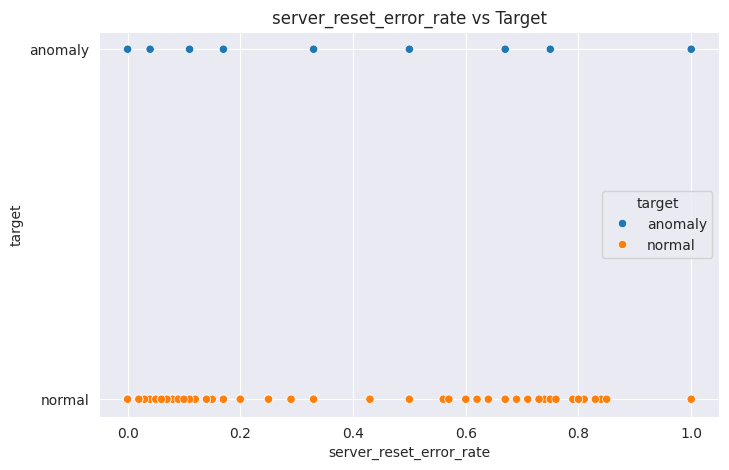

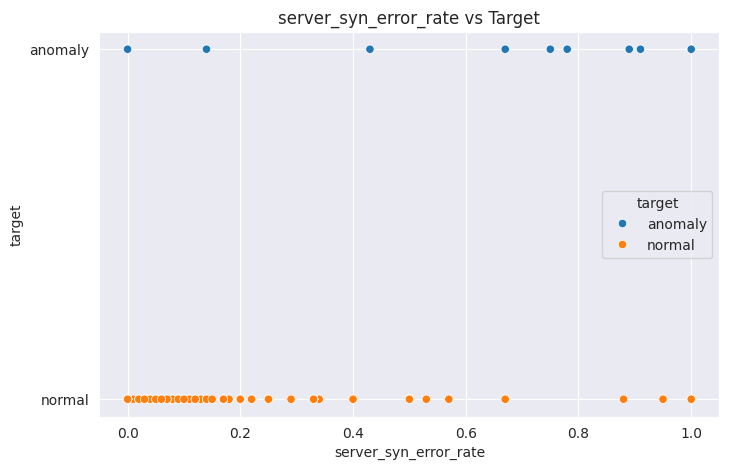

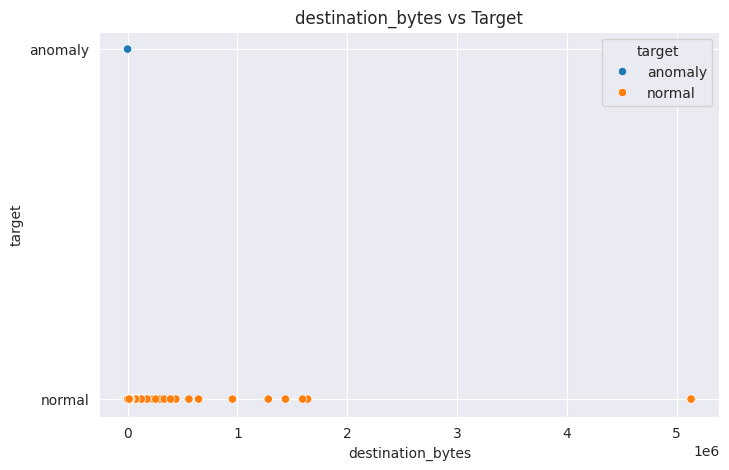

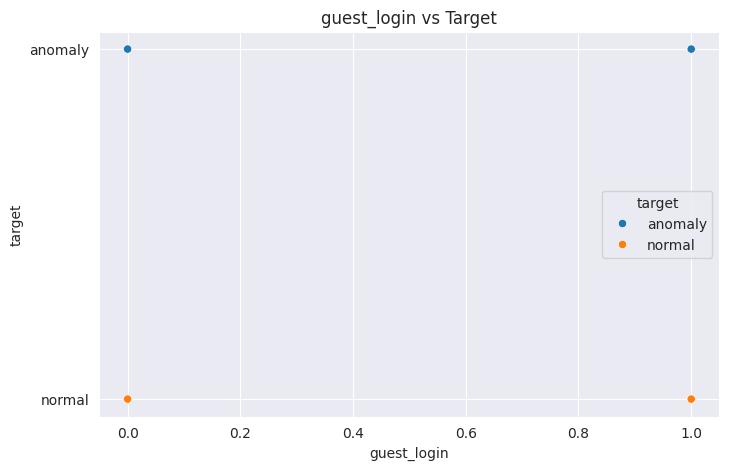

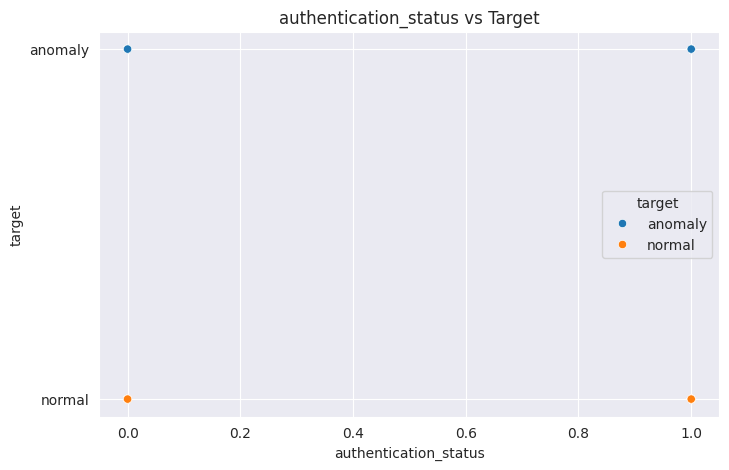

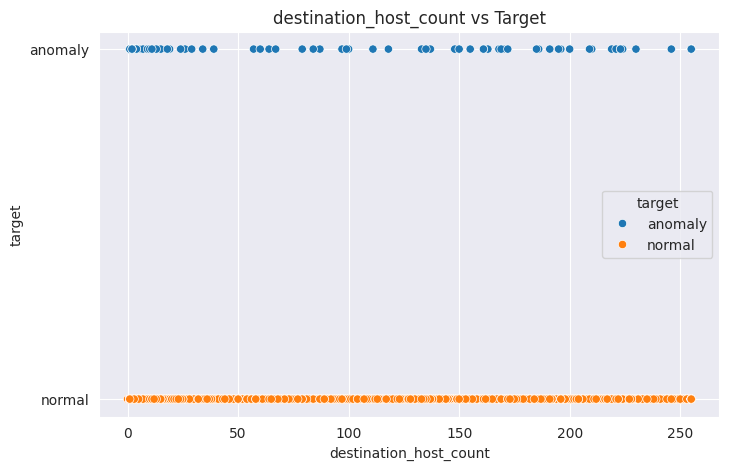

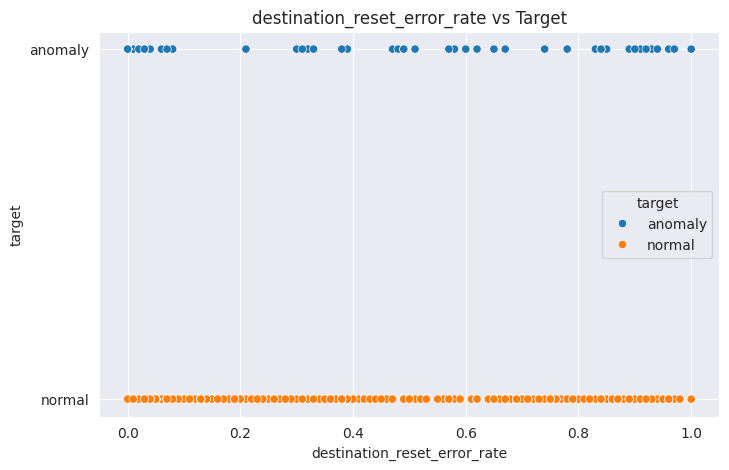

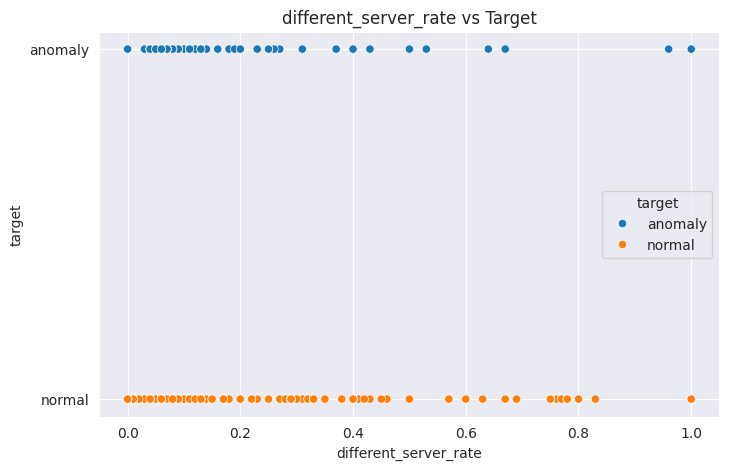

In [39]:
%matplotlib inline

for col in df.columns:
    if col != "target":
        plt.figure(figsize=(8, 5))  # Set figure size for each plot
        sns.scatterplot(x=col, y="target", hue="target", data=df)
        plt.title(f'{col} vs Target')
        plt.show() 


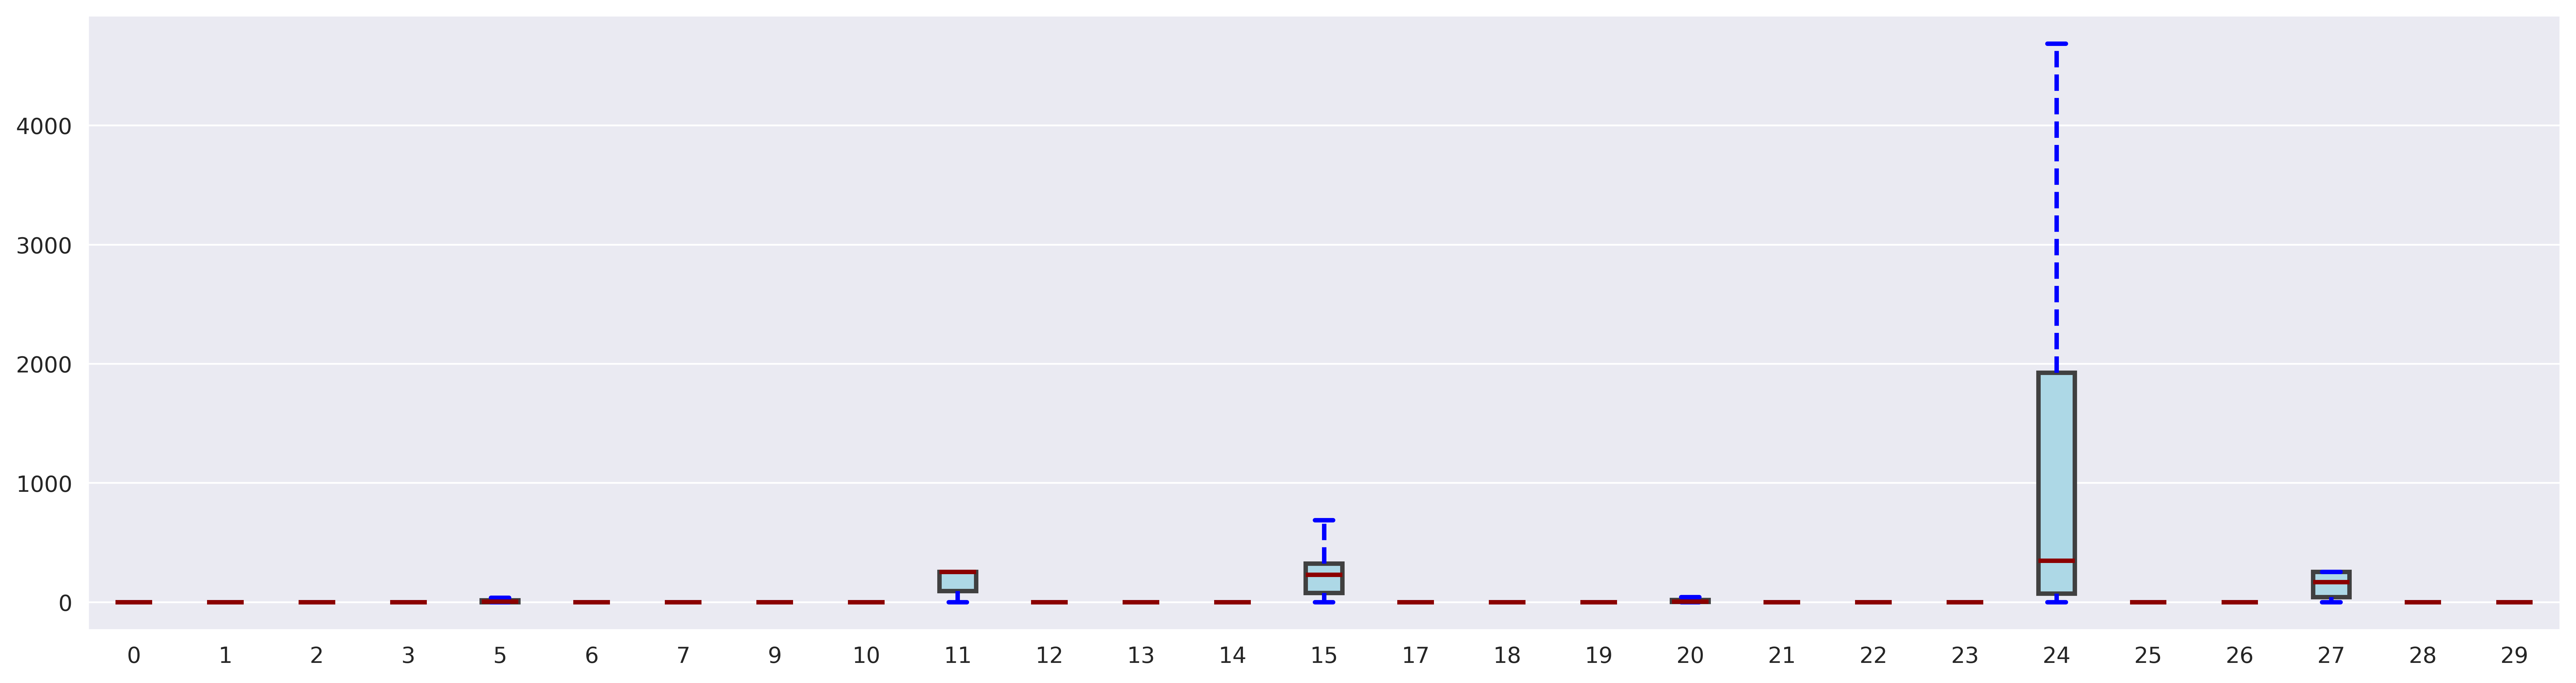

In [46]:
plt.figure(figsize=(20, 5), dpi=500)

sns.boxplot(
    data=df,
    showfliers=False,  # hide extreme outliers
    boxprops=dict(facecolor="lightblue", linewidth=2),  # box styling
    whiskerprops=dict(color="blue", linewidth=2, linestyle="--"),
    medianprops=dict(color="darkred", linewidth=2),
    capprops=dict(color="blue", linewidth=2),
    gap=1.5
)

plt.show()

In [31]:
[df.columns[11] , df.columns[15] , df.columns[24] , df.columns[27]]

['destination_host_server_count',
 'source_bytes',
 'destination_bytes',
 'destination_host_count']

## User Defined Functions (UDF)

In [44]:
def skimmer(df:pl.DataFrame)->dict:
    out ={}
    for col in df.columns:
        if(df[col].dtype == pl.Utf8):
            out[f"{col}"] =  {"col_unique_values": df[col].unique().to_list() , "data_type":df[col].dtype}
        else:
            out[f"{col}"] = {"col_values_range": [df[col].min(), df[col].max()],"data_type":df[col].dtype}
    return out

In [45]:
def TheAnalyzer(QuickSchema:dict) -> str:
    client = genai.Client(api_key=GEMINI_API_KEY)
    
    response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25",
    contents=f"Explain the schema of this dataset {skimmer(df)} , also can u get which dataset it origins from approximately",
    )
    return strip_markdown(response.text)
# print(TheAnalyzer(skimmer(df)))

## Data Description



Dataset Schema Explanation:
This dataset appears to describe network connection records, likely for the purpose of network intrusion or anomaly detection. Each record represents a single connection or aggregates statistics about recent connections. Here's a breakdown of the columns (features):
Basic Connection Features:

connection_time:
Data Type: Int64 (Integer)
Range: [0, 41476]
Description: Likely the duration of the connection in seconds or another time unit.


protocol:
Data Type: String (Categorical)
Unique Values: ['udp', 'icmp', 'tcp']
Description: The network protocol used for the connection (UDP, ICMP, TCP).


service_type:
Data Type: String (Categorical)
Unique Values: (List of 60+ services like 'http', 'ftp', 'smtp', 'telnet', 'private', 'other', etc.)
Description: The destination network service (e.g., web, file transfer, email). Some values like 'private' or 'other' suggest a catch-all or unknown service.


connection_status:
Data Type: String (Categorical)
Unique Values: ['SF', 'S1', 'OTH', 'REJ', 'RSTOS0', 'RSTR', 'S3', 'S2', 'S0', 'RSTO']
Description: Represents the status of the connection establishment and termination. These codes often correspond to combinations of TCP flags observed or specific states (e.g., 'SF' likely means Normal establishment and termination, 'REJ' likely means Rejected). This is similar to the 'flag' feature in KDD datasets.


source_bytes:
Data Type: Int64 (Integer)
Range: [0, 7665876]
Description: Number of data bytes sent from the source to the destination.


destination_bytes:
Data Type: Int64 (Integer)
Range: [0, 5131424]
Description: Number of data bytes sent from the destination to the source.



Content/Host-Based Features (Often related to specific behaviors within the connection):

suspicious_activity:
Data Type: Int64 (Integer)
Range: [0, 77]
Description: Count of 'hot' indicators or suspicious actions, like failed login attempts, accessing system control files, etc. Often called 'hot' in KDD datasets.


compromised_count:
Data Type: Int64 (Integer)
Range: [0, 884]
Description: Number of 'compromised' conditions or actions indicating potential system compromise (e.g., gaining root access).


guest_login:
Data Type: Int64 (Integer)
Range: [0, 1]
Description: Binary flag; 1 if the login was a 'guest' login, 0 otherwise.


authentication_status:
Data Type: Int64 (Integer)
Range: [0, 1]
Description: Binary flag; likely 1 if the user successfully logged in, 0 otherwise. Corresponds to logged_in in KDD datasets.


fragment_errors:
Data Type: Int64 (Integer)
Range: [0, 3]
Description: Count of network packets with fragmentation errors. Often called wrong_fragment in KDD datasets.



Time-Based Traffic Features (Statistics over the last ~2 seconds or 100 connections):


These features often look at connections to the same host or the same service within a recent time window.


connection_count:

Data Type: Int64 (Integer)
Range: [1, 511]
Description: Number of connections to the same destination host as the current connection in the past ~2 seconds (or sometimes 100 connections). Corresponds to count in KDD datasets.


server_request_count:
Data Type: Int64 (Integer)
Range: [1, 511]
Description: Number of connections to the same service (port number) as the current connection in the past ~2 seconds. Corresponds to srv_count in KDD datasets.


same_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that were to the same service. Corresponds to same_srv_rate in KDD datasets.


different_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that were to different services. Corresponds to diff_srv_rate in KDD datasets.


server_different_host_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that were from different source hosts. Corresponds to srv_diff_host_rate in KDD datasets.



Error Rate Features (Time-Based):

syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that had SYN errors (connection initiation errors). Corresponds to serror_rate in KDD datasets.


server_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that had SYN errors. Corresponds to srv_serror_rate in KDD datasets.


reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in connection_count) that had RST errors (reset errors). Corresponds to rerror_rate in KDD datasets.


server_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in server_request_count) that had RST errors. Corresponds to srv_rerror_rate in KDD datasets.



Host-Based Traffic Features (Statistics over the last ~100 connections to the destination host):


These features look at connections based on the destination host, often using a window of the last 100 connections targeting that host.


destination_host_count:

Data Type: Int64 (Integer)
Range: [0, 255]
Description: Number of connections (in the last 100) having the same destination host. Corresponds to dst_host_count in KDD datasets.


destination_host_server_count:
Data Type: Int64 (Integer)
Range: [0, 255]
Description: Number of connections (in the last 100) having the same destination host and using the same service. Corresponds to dst_host_srv_count in KDD datasets.


destination_same_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were to the same service. Corresponds to dst_host_same_srv_rate in KDD datasets.


destination_different_server_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were to different services. Corresponds to dst_host_diff_srv_rate in KDD datasets.


destination_same_source_port_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that were from the same source port. Corresponds to dst_host_same_src_port_rate in KDD datasets.


destination_server_different_host_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that were from different source hosts. Corresponds to dst_host_srv_diff_host_rate in KDD datasets.



Error Rate Features (Host-Based):

destination_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that had SYN errors. Corresponds to dst_host_serror_rate in KDD datasets.


destination_server_syn_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that had SYN errors. Corresponds to dst_host_srv_serror_rate in KDD datasets.


destination_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_count) that had RST errors. Corresponds to dst_host_rerror_rate in KDD datasets.


destination_server_reset_error_rate:
Data Type: Float64 (Float)
Range: [0.0, 1.0]
Description: Percentage of connections (in destination_host_server_count) that had RST errors. Corresponds to dst_host_srv_rerror_rate in KDD datasets.



Target/Class Label:

class:
Data Type: String (Categorical)
Unique Values: ['normal', 'anomaly']
Description: The classification label for the connection record, indicating whether it's considered normal traffic or an anomaly (potentially an attack).



Likely Origin Dataset:
Based on the feature names (e.g., connection_time -> duration, connection_status -> flag, connection_count -> count, server_request_count -> srv_count, the various _rate features), the types of features (basic connection info, content features, time-based traffic stats, host-based traffic stats), the specific values for categorical features (protocol, service_type, connection_status), and the presence of a class label ('normal', 'anomaly'), this schema strongly matches the KDD Cup 1999 (KDD'99) dataset or its refined version, the NSL-KDD dataset.

KDD Cup 1999: A widely used benchmark dataset for intrusion detection systems, derived from DARPA'98 IDS evaluation data. It contains various simulated attacks mixed with normal traffic.
NSL-KDD: A cleaned-up and improved version of KDD'99, addressing some of its statistical redundancy issues, making it more suitable for evaluating modern IDS.

The feature names in your schema are slightly different but map almost directly to the standard KDD feature names. The class feature being binary ('normal', 'anomaly') is common when using these datasets for binary classification tasks, although the original KDD'99 dataset had more specific attack type labels.


## SyntaxTesting

In [65]:
df["protocol"].unique()

protocol
str
"""icmp"""
"""tcp"""
"""udp"""


In [49]:
df.select(cs.string()).unique()

connection_status,protocol,service_type,class
str,str,str,str
"""SF""","""tcp""","""finger""","""normal"""
"""S0""","""tcp""","""exec""","""anomaly"""
"""S0""","""tcp""","""telnet""","""normal"""
"""REJ""","""tcp""","""Z39_50""","""anomaly"""
"""SF""","""tcp""","""IRC""","""normal"""
…,…,…,…
"""S0""","""tcp""","""auth""","""anomaly"""
"""S3""","""tcp""","""ftp_data""","""normal"""
"""REJ""","""tcp""","""iso_tsap""","""anomaly"""


In [83]:
html = strip_markdown("#your_text_string\nt")
print(html)

your_text_string
t


In [47]:
df["connection_count"].plot.hist()

alt.Chart(...)

In [9]:
df["target"]

target
str
"""anomaly"""
"""anomaly"""
"""anomaly"""
"""anomaly"""
"""anomaly"""
…
"""normal"""
"""normal"""
"""normal"""
